In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from matplotlib.contour import QuadContourSet
import cv2
from scipy.stats import ks_2samp, kstwobign, ksone
from tqdm import tqdm
import pcmdpy as ppy
%matplotlib inline

In [2]:
f = ppy.instrument.default_ngc3377_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model)

GPU acceleration not available. Continuing without.

In [3]:
g1 = ppy.galaxy.SSPSimple(np.array([0., -2., 3., 10.]))
g2 = ppy.galaxy.SSPSimple(np.array([0., -2., 3., 9.8]))
g3 = ppy.galaxy.SSPSimple(np.array([0., -2., 3., 9.6]))

In [4]:
pcmd1, _ = driv.simulate(g1, 256)
pcmd1v2, _ = driv.simulate(g1, 256)
pcmd2, _ = driv.simulate(g2, 256)
pcmd3, _ = driv.simulate(g3, 256)

In [5]:
# pcmd4, _ = driv.simulate(g1, 512)
# pcmd5, _ = driv.simulate(g2, 512)

In [6]:
# %%time
# pcmd_big, _ = driv.simulate(g1, 1024)

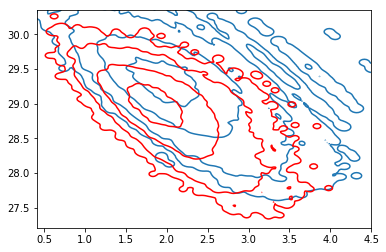

In [7]:
fig, [ax] = ppy.plotting.plot_pcmd_contours(pcmd1)
fig, [ax] = ppy.plotting.plot_pcmd_contours(pcmd2, ax=ax, color='r')
# fig, [ax] = ppy.plotting.plot_pcmd_contours(pcmd_big, ax=ax, color='g')


In [8]:
driv.initialize_data(pcmd1)

In [10]:
driv.loglike(pcmd1, like_mode=4)

0.0

# Contours

In [19]:
from scipy.ndimage import gaussian_filter as norm_kde
def get_contours(pcmd, levels, smooth=0.01, span=None):
    y, x = pcmd
    data = [x,y]
    if span is None:
        span = [0.999999426697 for i in range(2)]
    span = list(span)
    if len(span) != 2:
        raise ValueError("Dimension mismatch between samples and span.")
    for i, _ in enumerate(span):
        try:
            xmin, xmax = span[i]
        except:
            q = np.array([0.5 - 0.5 * span[i], 0.5 + 0.5 * span[i]])
            span[i] = np.percentile(data[i], list(100.*q))
    if (isinstance(smooth, int) or isinstance(smooth, float)):
        smooth = [smooth, smooth]
    bins, svalues = [], []
    for s in smooth:
        if isinstance(s, int):
            bins.append(s)
            svalues.append(0.)
        else:
            bins.append(int(round(2./s)))
            svalues.append(2.)
    H, X, Y = np.histogram2d(x.flatten(), y.flatten(), bins=bins,
                            range=list(map(np.sort, span)))
    if not np.all(svalues == 0.):
        H = norm_kde(H, svalues)
    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    V.sort()
    m = (np.diff(V) == 0)
    while np.any(m):
        V[np.where(m)[0][0]] *= 1.0 - 1e-4
        m = (np.diff(V) == 0)
    V.sort()
    # Compute the bin centers.
    X1, Y1 = 0.5 * (X[1:] + X[:-1]), 0.5 * (Y[1:] + Y[:-1])

    # Extend the array for the sake of the contours at the plot edges.
    H2 = H.min() + np.zeros((H.shape[0] + 4, H.shape[1] + 4))
    H2[2:-2, 2:-2] = H
    H2[2:-2, 1] = H[:, 0]
    H2[2:-2, -2] = H[:, -1]
    H2[1, 2:-2] = H[0]
    H2[-2, 2:-2] = H[-1]
    H2[1, 1] = H[0, 0]
    H2[1, -2] = H[0, -1]
    H2[-2, 1] = H[-1, 0]
    H2[-2, -2] = H[-1, -1]
    X2 = np.concatenate([X1[0] + np.array([-2, -1]) * np.diff(X1[:2]), X1,
                         X1[-1] + np.array([1, 2]) * np.diff(X1[-2:])])
    Y2 = np.concatenate([Y1[0] + np.array([-2, -1]) * np.diff(Y1[:2]), Y1,
                         Y1[-1] + np.array([1, 2]) * np.diff(Y1[-2:])])
    
    fig, ax = plt.subplots()
    contours = ax.contour(X2, Y2, H2.T, V)
    plt.close(fig)
#     contours = QuadContourSet(X2, Y2, H2.T, V)
    return dict(zip(levels[::-1], contours.allsegs))

In [20]:
def in_contour(pcmd, contour, factor=1000000.):
    y, x = pcmd
    assert len(x) == len(y)
    if len(contour) == 0:
        return np.array([False]*len(x))
    d = len(contour)
    if d == 1:
        contour = contour[0]
        n = len(contour)
        cv2_contour = (contour.reshape((n, 1, 2))*factor).astype(int)
        return np.array([cv2.pointPolygonTest(cv2_contour, (a,b), False) for a,b in zip(x*factor, y*factor)]) > 0   
    else:
        n_points = len(x)
        not_in = np.ones(n_points, dtype=bool)
        for sub_contour in contour:
            if np.sum(not_in) == 0:
                break
            n = len(sub_contour)
            cv2_contour = (sub_contour.reshape((n, 1, 2))*factor).astype(int)
            not_in[not_in] = (np.array([cv2.pointPolygonTest(cv2_contour, (a,b), False) for a,b in zip(x[not_in]*factor, y[not_in]*factor)]) < 0)
        return np.logical_not(not_in)

In [21]:
def contour_fracs(pcmd, contours):
    ys = {}
    xs = sorted(contours.keys())[::-1]
    is_good = np.ones(pcmd.shape[1], dtype=bool)
    for k in xs:
        cont = contours[k]
        is_good[is_good] = in_contour(pcmd[:,is_good], cont)
#         is_good = in_contour(pcmd, cont)
        ys[k] = is_good.mean()
    return xs, [ys[k] for k in xs]

In [23]:
def plot_agreement(data, model,
                   levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1], 'r--')
    contours = get_contours(model, levels)
    xs, ys = contour_fracs(data, contours)
    xs = [1.0] + list(xs) + [0.0]
    ys = [1.0] + list(ys) + [0.0]
    ax.plot(xs, ys, **kwargs)
    return ax

In [24]:
levels = np.linspace(0.0, 1.0, 21)[1:-1]
c = get_contours(pcmd1, levels)

In [26]:
def log_like_auto(model, data, levels):
    conts = get_contours(data, levels)
    _, x = contour_fracs(data, conts)
    _, y = contour_fracs(model, conts)    
    return np.log(ks_2samp(x, y).pvalue)

In [27]:
def log_like(model, data, levels, n=40):
    conts = get_contours(data, levels)
    _, x = contour_fracs(data, conts)
    _, y = contour_fracs(model, conts)
    d = np.max(np.abs(np.array(x)-np.array(y)))
    return max(ksone.logsf(d, 20), -1e10)

In [59]:
levels = np.linspace(0.0, 1.0, 11)[1:-1]
print(log_like(pcmd1, pcmd2, levels, n=40))

-7.6775654124583435


In [26]:
levels = np.linspace(0.0, 1.0, 11)[1:-1]
print(log_like(pcmd1, pcmd2, levels, n=20)) 

-7.24814387792424


In [36]:
n = 10
levels = np.linspace(0.0, 1.0, n+1)[1:-1]
log_like_auto(pcmd2, pcmd1, levels) - log_like_auto(pcmd3, pcmd1, levels)

6.893712697392182

In [37]:
n = 20
levels = np.linspace(0.0, 1.0, n+1)[1:-1]
log_like_auto(pcmd2, pcmd1, levels) - log_like_auto(pcmd3, pcmd1, levels)

13.369832651776305

In [38]:
n = 50
levels = np.linspace(0.0, 1.0, n+1)[1:-1]
log_like_auto(pcmd2, pcmd1, levels) - log_like_auto(pcmd3, pcmd1, levels)

28.440137242473327

In [39]:
n = 100
levels = np.linspace(0.0, 1.0, n+1)[1:-1]
log_like_auto(pcmd2, pcmd1, levels) - log_like_auto(pcmd3, pcmd1, levels)

57.101506661507905

In [48]:
n = 20
levels = np.linspace(0.0, 1.0, n+1)[1:-1]
log_like(pcmd2, pcmd1, levels, n=50) - log_like(pcmd1v2, pcmd1, levels, n=50)

-8.51426561802636

In [47]:
driv.loglike(pcmd2, like_mode=4) - driv.loglike(pcmd1v2, like_mode=4)

-47.80480214434148

In [45]:
a = ppy.utils.make_pcmd(ppy.utils.mean_mags(pcmd1))
b = ppy.utils.make_pcmd(ppy.utils.mean_mags(pcmd2))
((a-b)**2) / (2*np.array([0.05**2, 0.05**2]))

array([25.59426386, 42.47221141])